In [1]:
# @title Install dependencies
# @markdown In the first cell we'll install all of the necessary dependencies.
!apt-get update > /dev/null 2>&1
!apt-get -y install ffmpeg freeglut3-dev xvfb > /dev/null 2>&1  # For visualization.
!pip install imageio-ffmpeg --quiet

!pip install jedi --quiet
!pip install --upgrade pip setuptools wheel --quiet
!pip install dm-acme[jax] --quiet
!pip install dm-sonnet --quiet
!pip install trfl --quiet
!pip install pybullet --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 2.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-gbq 0.23.1 requires google-auth-oauthlib>=0.7.0, but you have google-auth-oauthlib

In [2]:
# Imports
import os
import shutil
import matplotlib
import pybullet_envs

from acme.utils import loggers
from acme.tf import networks
from acme.tf import utils as tf2_utils
from acme.agents.tf.d4pg import D4PG
from acme.agents.tf.ddpg import DDPG
from acme.agents.tf.dmpo import DistributionalMPO
from acme import wrappers, specs, environment_loop

import numpy as np
import sonnet as snt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from google.colab import drive
from IPython.display import HTML

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:440: UserWarning: WARN: The `registry.env_specs` property along with `EnvSpecTree` is deprecated. Please use `registry` directly as a dictionary instead.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:205: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.10/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:326: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
/usr/local/lib/python3.10/dist-packages/reverb/platform/default/ensure_tf_install.py:53: DeprecationWarning: distutil

In [3]:
# @title Import `pybullet` locomotion environments

from pybullet_envs.gym_locomotion_envs import HopperBulletEnv
from pybullet_envs.gym_locomotion_envs import Walker2DBulletEnv
from pybullet_envs.gym_locomotion_envs import HalfCheetahBulletEnv
from pybullet_envs.gym_locomotion_envs import AntBulletEnv
from pybullet_envs.gym_locomotion_envs import HumanoidBulletEnv

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

/usr/local/lib/python3.10/dist-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [5]:
def save_ckpt_to_drive(agent):
  """Saves agent checkpoint directory to Google Drive.

  WARNING: Will replace the entire content of the
  drive directory `/root/drive/MyDrive/acme_ckpt`.

  Args:
    agent: core.Actor
  """
  src = agent._learner._checkpointer._checkpoint_manager.directory
  dst = '/root/drive/MyDrive/acme_ckpt'
  if os.path.exists(dst):
    shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Saved {src} to {dst}')


def restore_ckpt_from_drive(agent):
  """Restores agent checkpoint directory from Google Drive.

  The name of the local checkpoint directory will be different
  than it was when the checkpoint was originally saved.
  This is because `acme` checkpoiner creates a new directory
  upon restart.

  WARNING: Will replace the entire content of the local
  checkpoint directory (if it exists already).

  Args:
    agent: core.Actor
  """
  src = '/root/drive/MyDrive/acme_ckpt'
  dst = agent._learner._checkpointer._checkpoint_manager.directory
  if os.path.exists(dst):
        shutil.rmtree(dst)
  shutil.copytree(src, dst)
  print(f'Restored {dst} from {src}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

In [7]:
def make_networks_d4pg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for D4PG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = snt.Sequential([
      networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes,
              activate_final=True),
      ),
      networks.DiscreteValuedHead(vmin=vmin,
                                  vmax=vmax,
                                  num_atoms=num_atoms)
      ])

  return policy_network, critic_network


def make_networks_ddpg(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                      ):
  """Networks for DDPG agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes + (action_size,)),
      networks.TanhToSpec(spec=action_spec)
      ])
  critic_network = networks.CriticMultiplexer(
          action_network=networks.ClipToSpec(action_spec),
          critic_network=networks.LayerNormMLP(
              layer_sizes=critic_layer_sizes + (1,),
              activate_final=False),
              )

  return policy_network, critic_network


def make_networks_dmpo(action_spec,
                       policy_layer_sizes=(256, 256, 256),
                       critic_layer_sizes=(512, 512, 256),
                       vmin=-150.,
                       vmax=150.,
                       num_atoms=51,
                      ):
  """Networks for DMPO agent."""
  action_size = np.prod(action_spec.shape, dtype=int)

  policy_network = snt.Sequential([
      tf2_utils.batch_concat,
      networks.LayerNormMLP(layer_sizes=policy_layer_sizes,
                            activate_final=True),
      networks.MultivariateNormalDiagHead(
          action_size,
          min_scale=1e-6,
          tanh_mean=False,
          init_scale=0.7,
          fixed_scale=False,
          use_tfd_independent=True)
  ])

  # The multiplexer concatenates the (maybe transformed) observations/actions.
  critic_network = networks.CriticMultiplexer(
      action_network=networks.ClipToSpec(action_spec),
      critic_network=networks.LayerNormMLP(layer_sizes=critic_layer_sizes,
                                           activate_final=True),
                                           )
  critic_network = snt.Sequential([
                                   critic_network,
                                   networks.DiscreteValuedHead(vmin=vmin,
                                                               vmax=vmax,
                                                               num_atoms=num_atoms)
                                   ])

  return policy_network, critic_network

In [8]:
pybullet_envs.getList()

/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:421: UserWarning: WARN: The `registry.all` method is deprecated. Please use `registry.values` instead.
  logger.warn(


['- HumanoidDeepMimicBackflipBulletEnv-v1',
 '- HumanoidDeepMimicWalkBulletEnv-v1',
 '- CartPoleBulletEnv-v1',
 '- CartPoleContinuousBulletEnv-v0',
 '- MinitaurBulletEnv-v0',
 '- MinitaurBulletDuckEnv-v0',
 '- RacecarBulletEnv-v0',
 '- RacecarZedBulletEnv-v0',
 '- KukaBulletEnv-v0',
 '- KukaCamBulletEnv-v0',
 '- InvertedPendulumBulletEnv-v0',
 '- InvertedDoublePendulumBulletEnv-v0',
 '- InvertedPendulumSwingupBulletEnv-v0',
 '- ReacherBulletEnv-v0',
 '- PusherBulletEnv-v0',
 '- ThrowerBulletEnv-v0',
 '- Walker2DBulletEnv-v0',
 '- HalfCheetahBulletEnv-v0',
 '- AntBulletEnv-v0',
 '- HopperBulletEnv-v0',
 '- HumanoidBulletEnv-v0',
 '- HumanoidFlagrunBulletEnv-v0',
 '- HumanoidFlagrunHarderBulletEnv-v0',
 '- MinitaurExtendedEnv-v0',
 '- MinitaurReactiveEnv-v0',
 '- MinitaurBallGymEnv-v0',
 '- MinitaurTrottingEnv-v0',
 '- MinitaurStandGymEnv-v0',
 '- MinitaurAlternatingLegsEnv-v0',
 '- MinitaurFourLegStandEnv-v0',
 '- KukaDiverseObjectGrasping-v0']

In [9]:
class Hopper(HopperBulletEnv):

  def __init__(self, render=False, episode_steps=1000):
    """Modifies `__init__` in `HopperBulletEnv` parent class."""
    self.episode_steps = episode_steps
    super().__init__(render=render)

  def reset(self):
    """Modifies `reset` in `WalkerBaseBulletEnv` base class."""
    self.step_counter = 0
    return super().reset()

  def _isDone(self):
    """Modifies `_isDone` in `WalkerBaseBulletEnv` base class."""
    return (self.step_counter == self.episode_steps
            or super()._isDone())

  def step(self, a):
    """Fully overrides `step` in `WalkerBaseBulletEnv` base class."""

    self.step_counter += 1

    # if multiplayer, action first applied to all robots,
    # then global step() called, then _step() for all robots
    # with the same actions
    if not self.scene.multiplayer:
      self.robot.apply_action(a)
      self.scene.global_step()

    state = self.robot.calc_state()  # also calculates self.joints_at_limit

    # state[0] is body height above ground, body_rpy[1] is pitch
    self._alive = float(self.robot.alive_bonus(state[0] + self.robot.initial_z,
                                               self.robot.body_rpy[1]))
    done = self._isDone()
    if not np.isfinite(state).all():
      print("~INF~", state)
      done = True

    potential_old = self.potential
    self.potential = self.robot.calc_potential()
    progress = float(self.potential - potential_old)

    feet_collision_cost = 0.0
    for i, f in enumerate(self.robot.feet):
      contact_ids = set((x[2], x[4]) for x in f.contact_list())
      if (self.ground_ids & contact_ids):
        self.robot.feet_contact[i] = 1.0
      else:
        self.robot.feet_contact[i] = 0.0

    # let's assume we have DC motor with controller, and reverse current braking
    electricity_cost = self.electricity_cost * float(
        np.abs(a * self.robot.joint_speeds).mean())
    electricity_cost += self.stall_torque_cost * float(np.square(a).mean())

    joints_at_limit_cost = float(self.joints_at_limit_cost * self.robot.joints_at_limit)

    self.rewards = [
                    self._alive, progress, electricity_cost,
                    joints_at_limit_cost, feet_collision_cost
                    ]
    self.HUD(state, a, done)
    self.reward += sum(self.rewards)

    return state, sum(self.rewards), bool(done), {}

In [10]:
env = Hopper(render=False)

env = wrappers.GymWrapper(env)
env = wrappers.SinglePrecisionWrapper(env)

action_spec = env.action_spec()  # Specifies action shape and dimensions.
env_spec = specs.make_environment_spec(env)  # Environment specifications.

In [11]:
# x and y coordinates of the target location.
env.robot.walk_target_x, env.robot.walk_target_y

(1000.0, 0)

/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


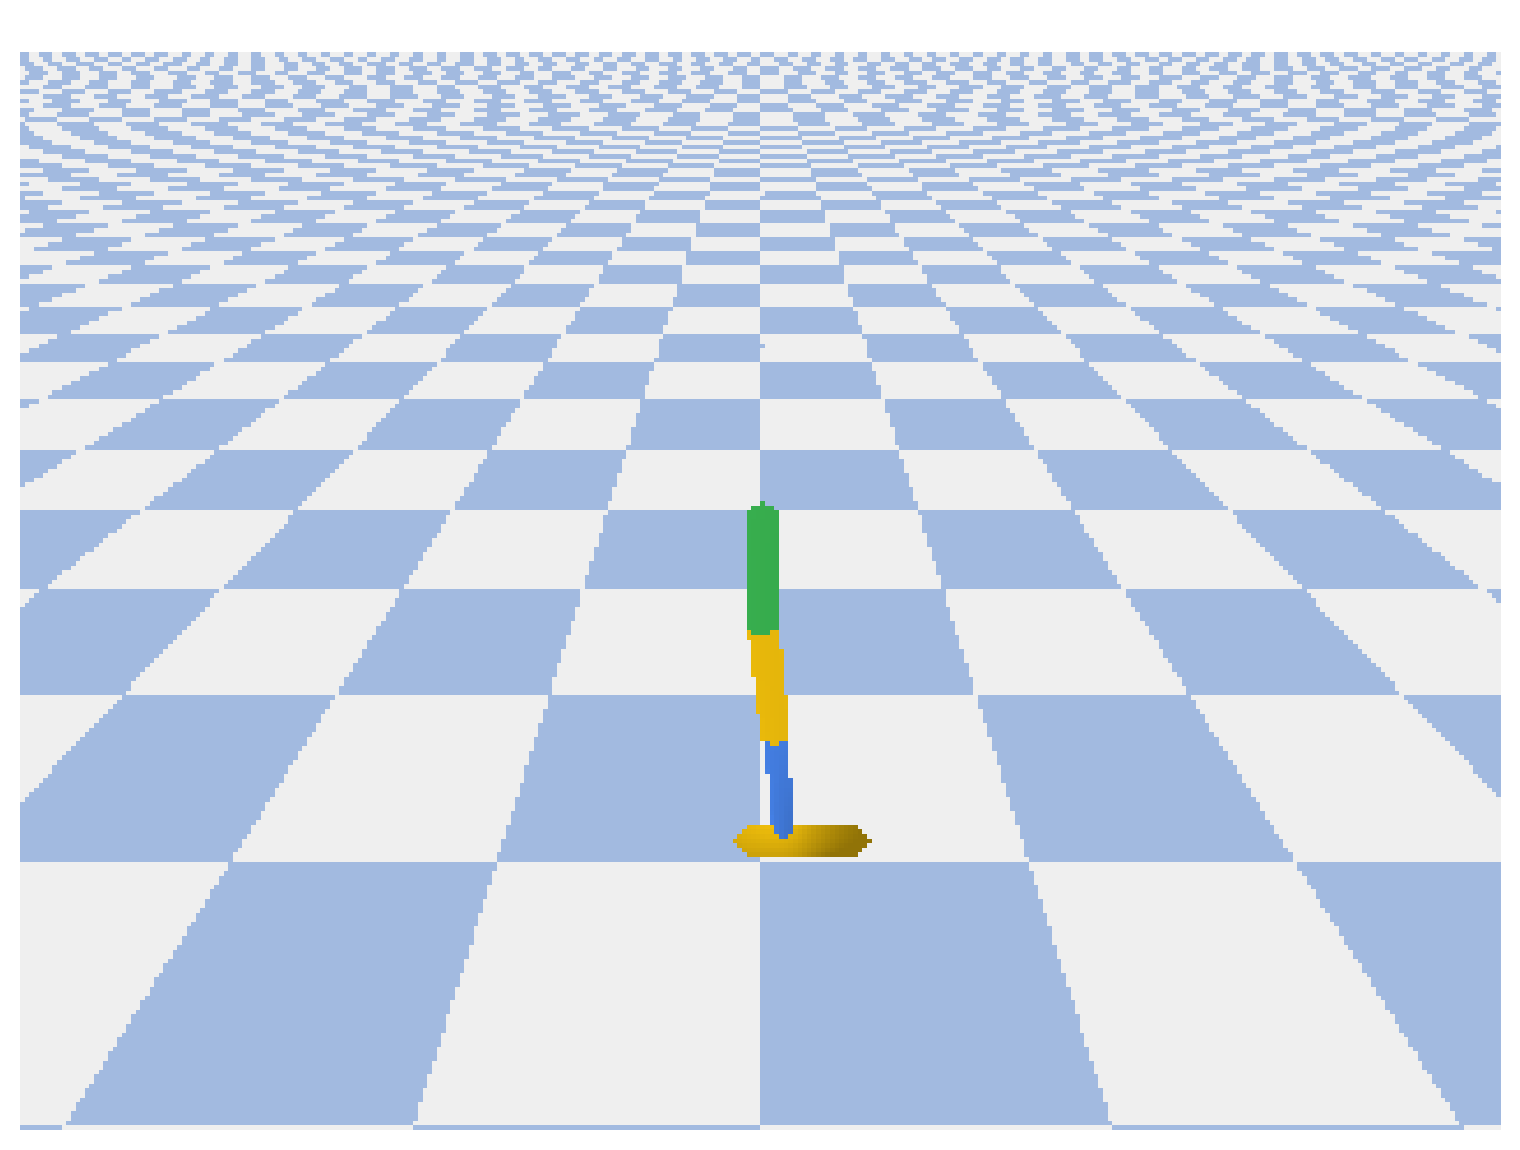

In [12]:
_ = env.reset()

frame = env.environment.render(mode='rgb_array')
plt.imshow(frame)
plt.axis('off')
plt.show()

In [13]:
# Run env for n_steps, apply random actions, and show video.
n_steps = 200

frames = []
timestep = env.reset()
for _ in range(n_steps):
  # Random control of actuators.
  action = np.random.uniform(action_spec.minimum,
                             action_spec.maximum,
                             size=action_spec.shape)
  timestep = env.step(action)
  frames.append(env.environment.render(mode='rgb_array'))

display_video(frames, framerate=20)

In [14]:
print('Actions:\n', env_spec.actions)
print('Observations:\n', env_spec.observations)
print('Rewards:\n', env_spec.rewards)

Actions:
 BoundedArray(shape=(3,), dtype=dtype('float32'), name='action', minimum=[-1. -1. -1.], maximum=[1. 1. 1.])
Observations:
 BoundedArray(shape=(15,), dtype=dtype('float32'), name='observation', minimum=[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf], maximum=[inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf])
Rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
# Cartesian coordinates of body parts.
for body_part in env.robot.parts.keys():
  print(f"{body_part:10} {env.robot.parts[body_part].pose().xyz()}")

link0_2    [0.84265529 0.         0.        ]
torso      [-0.23782615  0.          0.90398591]
link0_3    [0.84265529 0.         0.27544804]
link0_4    [0.84265529 0.         0.27544804]
link0_6    [-0.06494908  0.          0.80341982]
thigh      [0.09961157 0.         0.64997676]
link0_8    [0.26417223 0.         0.49653369]
leg        [0.12213861 0.         0.29079974]
link0_10   [-0.01989501  0.          0.08506579]
foot       [0.04476547 0.         0.09170069]
floor      [0. 0. 0.]


In [16]:
# Cartesian components of robot speed.
env.robot_body.speed()

array([-0.69543265,  0.        , -3.64424684])

In [17]:
learner_log_every = 60.  # Learner logging frequency, seconds.
loop_log_every = 60.  # Environment loop logging frequency, seconds.
checkpoint = True  # Checkpoint saved every 10 minutes.

learner_logger = loggers.TerminalLogger(label='Learner',
                                        time_delta=learner_log_every,
                                        print_fn=print)
loop_logger = loggers.TerminalLogger(label='Environment Loop',
                                     time_delta=loop_log_every,
                                     print_fn=print)

# Note: optimizers can be passed only to the D4PG and DMPO agents.
# The optimizer for DDPG is hard-coded in the agent class.
policy_optimizer = snt.optimizers.Adam(1e-4)
critic_optimizer = snt.optimizers.Adam(1e-4)

In [18]:
# Create networks.
policy_network, critic_network = make_networks_d4pg(action_spec)

# Create agent.
agent = D4PG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network=tf2_utils.batch_concat, # Identity Op.
             policy_optimizer=policy_optimizer,
             critic_optimizer=critic_optimizer,
             logger=learner_logger,
             checkpoint=checkpoint)

In [19]:
num_steps = 1000 # 100_000  # Number of environment loop steps. Adjust as needed!

loop = environment_loop.EnvironmentLoop(env, agent, logger=loop_logger)

# Start training!
loop.run(num_episodes=None,
         num_steps=num_steps)

In [20]:
# Run the environment with the learned policy and display video.
n_steps = 500

frames = []  # Frames for video.
reward = [[]]  # Reward at every timestep.
timestep = env.reset()
for _ in range(n_steps):
  frames.append(env.environment.render(mode='rgb_array').copy())
  action = agent.select_action(timestep.observation)
  timestep = env.step(action)

  # `timestep.reward` is None when episode terminates.
  if timestep.reward:
    # Old episode continues.
    reward[-1].append(timestep.reward.item())
  else:
    # New episode begins.
    reward.append([])

display_video(frames)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


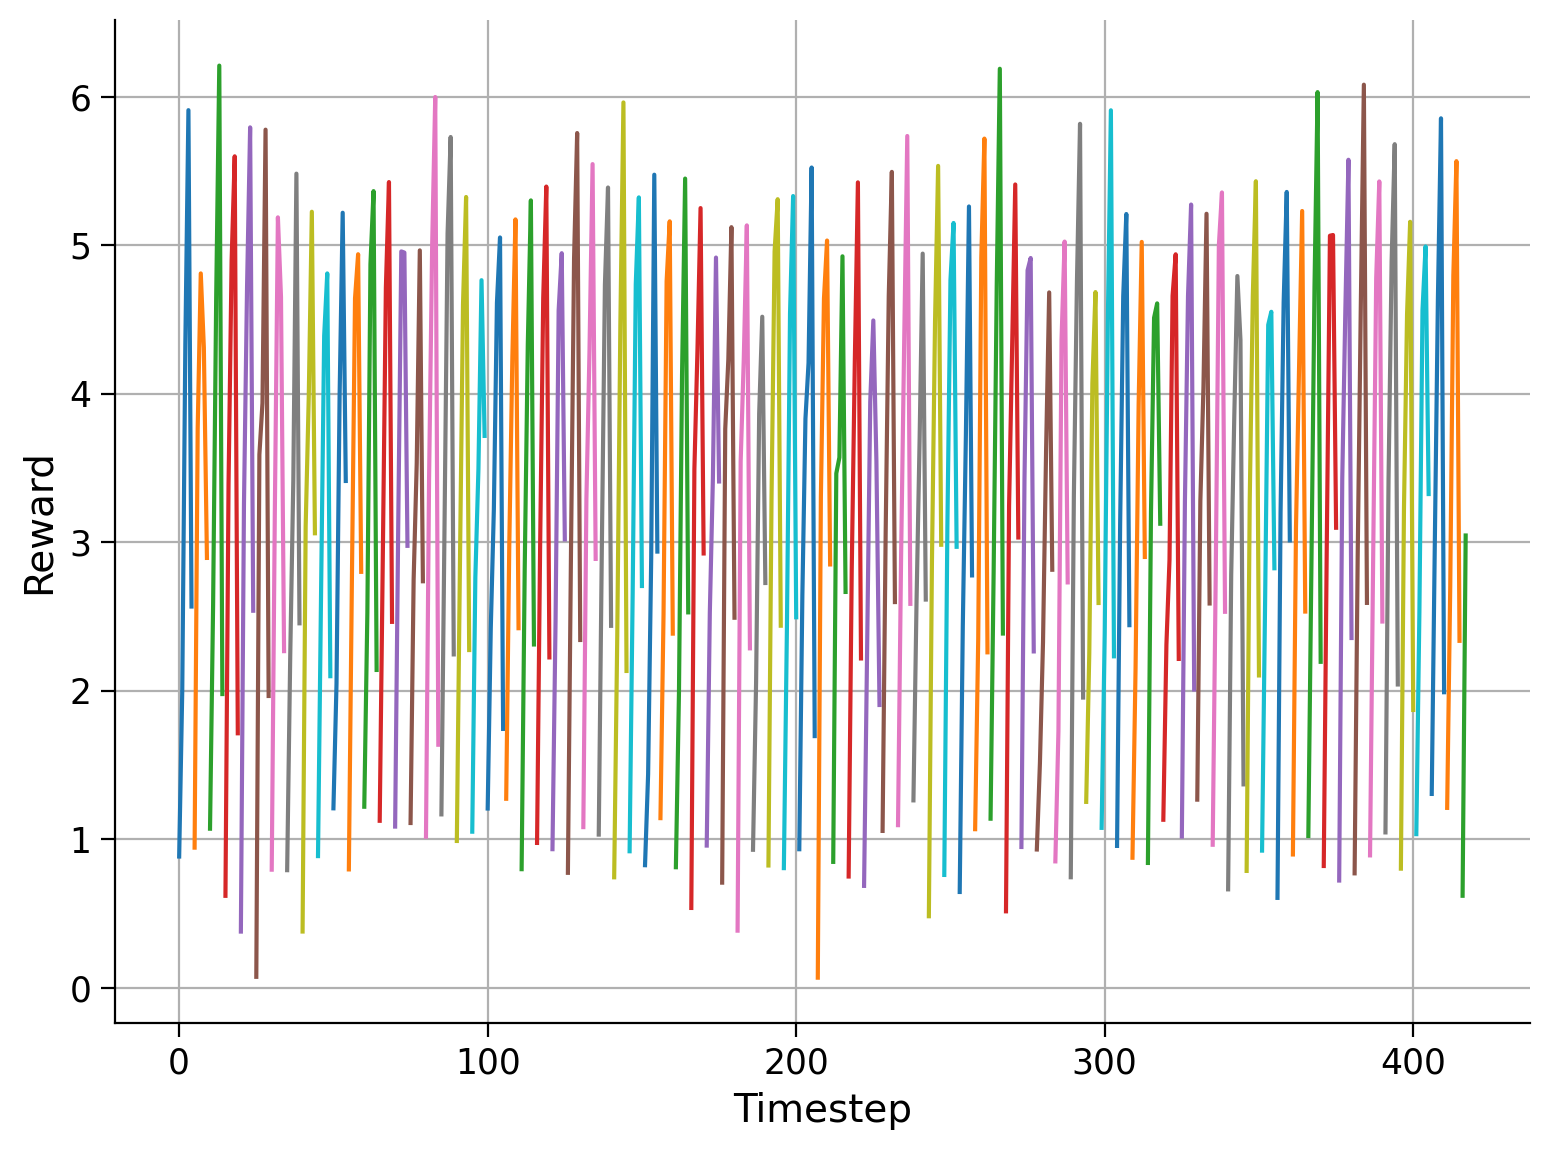

In [21]:
env_step = 0
for episode in reward:
  plt.plot(np.arange(env_step, env_step+len(episode)), episode)
  env_step += len(episode)
plt.xlabel('Timestep', fontsize=14)
plt.ylabel('Reward', fontsize=14)
plt.grid()
plt.show()

In [22]:
for i, episode in enumerate(reward):
  print(f"Total reward in episode {i}: {sum(episode):.2f}")

Total reward in episode 0: 15.70
Total reward in episode 1: 16.73
Total reward in episode 2: 16.49
Total reward in episode 3: 16.22
Total reward in episode 4: 16.68
Total reward in episode 5: 15.35
Total reward in episode 6: 16.10
Total reward in episode 7: 14.39
Total reward in episode 8: 15.75
Total reward in episode 9: 14.86
Total reward in episode 10: 15.87
Total reward in episode 11: 15.96
Total reward in episode 12: 16.12
Total reward in episode 13: 16.62
Total reward in episode 14: 17.08
Total reward in episode 15: 15.10
Total reward in episode 16: 17.08
Total reward in episode 17: 17.31
Total reward in episode 18: 16.03
Total reward in episode 19: 15.79
Total reward in episode 20: 18.26
Total reward in episode 21: 16.10
Total reward in episode 22: 15.56
Total reward in episode 23: 16.22
Total reward in episode 24: 15.93
Total reward in episode 25: 16.72
Total reward in episode 26: 17.10
Total reward in episode 27: 16.56
Total reward in episode 28: 15.67
Total reward in episode 

In [23]:
# Mount drive. -- You may want to add your gDrive
drive.mount('/root/drive')

Mounted at /root/drive


In [24]:
# Save agent checkpoint to drive.
save_ckpt_to_drive(agent)

Saved /root/acme/70f8b8f6-76e8-11ef-84b1-0242ac1c000c/checkpoints/d4pg_learner to /root/drive/MyDrive/acme_ckpt


In [25]:
# Restore checkpoint from drive.
restore_ckpt_from_drive(agent)

Restored /root/acme/70f8b8f6-76e8-11ef-84b1-0242ac1c000c/checkpoints/d4pg_learner from /root/drive/MyDrive/acme_ckpt


In [26]:
# Unmount drive.
drive.flush_and_unmount()

In [27]:
# Create networks.
policy_network, critic_network = make_networks_dmpo(action_spec)

# Create agent.
agent = DistributionalMPO(environment_spec=env_spec,
                          policy_network=policy_network,
                          critic_network=critic_network,
                          observation_network=tf2_utils.batch_concat,
                          policy_optimizer=policy_optimizer,
                          critic_optimizer=critic_optimizer,
                          logger=learner_logger,
                          checkpoint=False)

Instructions for updating:
Please pass an integer value for `reinterpreted_batch_ndims`. The current behavior corresponds to `reinterpreted_batch_ndims=tf.size(distribution.batch_shape_tensor()) - 1`.


In [28]:
# Create networks.
policy_network, critic_network = make_networks_ddpg(action_spec)

# Create agent.
agent = DDPG(environment_spec=env_spec,
             policy_network=policy_network,
             critic_network=critic_network,
             observation_network= tf2_utils.batch_concat, # Identity Op.
             logger=learner_logger,
             checkpoint=checkpoint)